## Daily Weather Forecasting for Cairo using LSTM Networks

### Objective: 
This project aims to develop a Long Short-Term Memory (LSTM) model to predict daily weather conditions in Cairo, Egypt, using historical meteorological data. The model forecasts short-term variables such as temperature, humidity, and solar radiation, helping users visualize and anticipate daily weather trends.

The final product is an interactive Streamlit web application where users can:

View next-day weather forecasts(mean temperature),

Explore historical patterns, and

Visualize key climate metrics for Cairo over multiple years.

#### Motivation:

Cairo’s desert climate exhibits significant temperature fluctuations, making short-term forecasting valuable for agriculture, energy management, and daily planning. Traditional statistical methods often fail to capture complex nonlinear temporal dependencies — hence, this project leverages LSTMs, which are well-suited for time-dependent data with long-range relationships.

#### Key Steps:

- Data Collection & Cleaning: Process the Cairo Weather and Climate Dataset (daily records with timestamps standardized to GMT+0).

- Exploratory Data Analysis (EDA): Understand temporal patterns, seasonal trends, and correlations between atmospheric features.

- Model Development: Build and tune an LSTM model to predict next-day temperature (and optionally other metrics).

- Evaluation: Use MAE/RMSE to assess performance against baseline models.

- Deployment: Create a Streamlit dashboard for real-time visualization and forecasting.

In [2]:
import sys
print(sys.executable)

C:\Users\adewu\AppData\Local\Programs\Python\Python312\python.exe


In [20]:
!{sys.executable} -m pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 2.8 MB/s eta 0:00:04
   ------------ --------------------------- 2.9/9.6 MB 6.0 MB/s eta 0:00:02
   ------------------------ --------------- 5.8/9.6 MB 8.4 MB/s eta 0:00:01
   ------------------------------------ --- 8.7/9.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 9.2 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   --------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\adewu\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [6]:
# Setup & Imports
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('coolwarm')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

In [8]:
# Load
df = pd.read_csv("Cairo-Weather.csv")

# Inspect first few rows
df.head()

,date,weather_code,temperature_2m_max,temperature_2m_mean,temperature_2m_min,apparent_temperature_mean,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,shortwave_radiation_sum,et0_fao_evapotranspiration_sum,relative_humidity_2m_mean,relative_humidity_2m_max,relative_humidity_2m_min,pressure_msl_mean,pressure_msl_max,pressure_msl_min,cloud_cover_max,cloud_cover_mean,cloud_cover_min,dew_point_2m_mean,dew_point_2m_max,dew_point_2m_min,surface_pressure_mean,surface_pressure_max,surface_pressure_min,winddirection_10m_dominant,wind_speed_10m_mean,wind_gusts_10m_mean,wind_speed_10m_min,wind_gusts_10m_min,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_min,wet_bulb_temperature_2m_mean,vapour_pressure_deficit_max,soil_moisture_0_to_100cm_mean,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_moisture_28_to_100cm_mean,soil_temperature_0_to_100cm_mean,soil_temperature_0_to_7cm_mean,soil_temperature_28_to_100cm_mean,soil_temperature_7_to_28cm_mean
0,2000-01-01 00:00:00+00:00,3.0,21.972,16.036583,11.772,15.440319,21.002140,11.183245,946702240,946739119,36881.254,31014.309,0.0,0.0,0.0,0.0,13.397612,26.640000,14.643493,2.082784,11.50,2.082784,82.305640,99.67151,53.405457,1016.62920,1018.7,1015.4,100.0,48.125000,0.0,12.624082,13.472,11.322,1013.27264,1015.34020,1012.11365,14.643493,9.844768,18.660000,6.034700,8.280000,15.874693,11.411108,13.834575,1.230186,0.067163,0.065042,0.065,0.068,19.657646,17.024084,20.580332,17.372000
1,2000-01-02 00:00:00+00:00,51.0,22.172,17.465748,13.922,16.408321,20.951057,13.253859,946788653,946825560,36909.152,25836.818,0.3,0.3,0.0,2.0,17.317460,33.120000,41.603683,2.416157,11.61,2.416157,74.822710,99.35310,48.410750,1013.76660,1016.4,1010.8,100.0,89.125000,51.0,12.486584,13.972,10.772,1010.43600,1013.01990,1007.45935,41.603683,12.716782,24.869997,5.804825,15.119999,15.344246,13.663824,14.338646,1.378825,0.067204,0.065625,0.065,0.068,19.865147,18.386583,20.571997,17.934502
2,2000-01-03 00:00:00+00:00,51.0,18.222,15.282417,12.472,14.032104,15.869614,10.851530,946875066,946912003,36939.734,6323.698,0.5,0.5,0.0,3.0,17.673029,32.760002,308.437320,1.397328,5.18,1.397328,77.427830,94.95394,52.538770,1012.12920,1013.9,1010.7,100.0,87.833336,37.0,11.117833,13.822,7.972,1008.77900,1010.52185,1007.34424,308.437320,11.205613,21.990000,5.634891,13.679999,14.025942,10.620736,12.675635,0.978643,0.067612,0.071458,0.065,0.068,19.750376,16.353249,20.571997,18.065752
3,2000-01-04 00:00:00+00:00,51.0,15.822,12.326167,9.372,9.451612,11.841578,5.701871,946961477,946998447,36972.926,33849.780,0.1,0.1,0.0,1.0,22.104116,40.320000,275.565980,2.154280,10.96,2.154280,69.800130,92.54666,52.454323,1014.28754,1015.4,1013.1,83.0,34.041668,0.0,6.705335,9.672,3.822,1010.89545,1012.02386,1009.69415,275.565980,14.142585,25.710001,8.654986,13.320000,10.626269,6.219323,9.062448,0.844776,0.067927,0.075958,0.065,0.068,19.382334,14.249084,20.530336,17.157420
4,2000-01-05 00:00:00+00:00,3.0,14.472,10.642833,7.622,6.559723,8.931084,3.915077,947047886,947084892,37008.650,26566.559,0.0,0.0,0.0,0.0,28.266306,54.000000,253.735660,2.290453,9.48,2.290453,62.888935,77.68418,43.413612,1015.23760,1017.3,1013.7,93.0,32.666668,0.0,3.613667,4.472,2.172,1011.82210,1013.87170,1010.25890,253.735660,17.759550,33.720000,13.378250,23.039999,8.362817,5.433388,6.804127,0.933858,0.068149,0.079125,0.065,0.068,18.901980,12.338666,20.451166,15.778251


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               9406 non-null   object 
 1   weather_code                       9406 non-null   float64
 2   temperature_2m_max                 9406 non-null   float64
 3   temperature_2m_mean                9406 non-null   float64
 4   temperature_2m_min                 9406 non-null   float64
 5   apparent_temperature_mean          9406 non-null   float64
 6   apparent_temperature_max           9406 non-null   float64
 7   apparent_temperature_min           9406 non-null   float64
 8   sunrise                            9406 non-null   int64  
 9   sunset                             9406 non-null   int64  
 10  daylight_duration                  9406 non-null   float64
 11  sunshine_duration                  9406 non-null   float

In [10]:
df.describe()

,weather_code,temperature_2m_max,temperature_2m_mean,temperature_2m_min,apparent_temperature_mean,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,shortwave_radiation_sum,et0_fao_evapotranspiration_sum,relative_humidity_2m_mean,relative_humidity_2m_max,relative_humidity_2m_min,pressure_msl_mean,pressure_msl_max,pressure_msl_min,cloud_cover_max,cloud_cover_mean,cloud_cover_min,dew_point_2m_mean,dew_point_2m_max,dew_point_2m_min,surface_pressure_mean,surface_pressure_max,surface_pressure_min,winddirection_10m_dominant,wind_speed_10m_mean,wind_gusts_10m_mean,wind_speed_10m_min,wind_gusts_10m_min,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_min,wet_bulb_temperature_2m_mean,vapour_pressure_deficit_max,soil_moisture_0_to_100cm_mean,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_moisture_28_to_100cm_mean,soil_temperature_0_to_100cm_mean,soil_temperature_0_to_7cm_mean,soil_temperature_28_to_100cm_mean,soil_temperature_7_to_28cm_mean
count,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9.406000e+03,9.406000e+03,9406.000000,9406.000000,9406.000000,9406.000000,9406.0,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000,9406.000000
mean,4.481714,29.340517,22.628763,16.124862,21.582805,27.840265,15.989930,1.352995e+09,1.353038e+09,43848.976404,39014.092251,0.056645,0.056645,0.0,0.166277,18.501729,35.382075,185.962469,5.544075,21.085656,5.544075,51.530326,82.926853,26.112026,1013.857247,1015.626802,1011.959079,54.523815,19.139472,2.050925,10.289810,13.916139,6.451351,1010.582177,1012.324981,1008.733887,185.962469,11.744374,23.507344,5.955681,11.584108,17.070535,13.410194,15.380219,3.322555,0.110608,0.067788,0.079195,0.123933,25.609180,25.645980,25.599009,25.631778
std,11.859672,7.071182,6.196291,5.442253,7.563604,8.506915,7.302516,2.346125e+08,2.346125e+08,4803.267941,5959.202923,0.625654,0.625654,0.0,0.918933,4.789046,7.908051,139.833387,2.082985,6.338756,2.082985,10.875966,12.878141,9.033590,4.957884,5.045313,5.077279,40.217606,22.825492,9.913065,5.213247,5.448468,5.105713,4.886623,4.979913,4.999569,139.833387,3.337502,5.590162,3.084505,4.788003,4.339469,5.177551,4.677362,1.531199,0.039436,0.039969,0.038291,0.047757,5.181562,7.360442,4.757410,6.422973
min,0.000000,11.216499,8.374083,3.122000,2.778920,4.312347,-1.024463,9.467022e+08,9.467391e+08,36745.690000,0.000000,0.000000,0.000000,0.0,0.000000,3.826853,12.959999,0.000005,1.106199,4.840000,1.106199,9.430376,15.536795,3.133519,999.824770,1003.600000,992.600000,0.000000,0.000000,0.000000,-8.415500,-5.178000,-15.483500,996.518000,1000.343400,989.288760,0.000005,1.818873,8.010000,0.000000,0.720000,4.795015,-0.555420,3.103459,0.500188,0.028905,-0.000542,-0.000208,0.040000,15.933688,9.665750,16.921999,11.842832
25%,0.000000,23.022001,16.931938,11.417875,14.806447,20.486480,9.555064,1.149843e+09,1.149894e+09,39184.601000,34665.120000,0.000000,0.000000,0.0,0.000000,15.379206,30.599998,33.054505,3.601004,15.032500,3.601004,45.622967,76.783056,19.692328,1009.916700,1011.600000,1008.000000,10.000000,1.083333,0.000000,6.280521,9.716499,2.722000,1006.713638,1008.393305,1004.850537,33.054505,9.491425,20.024998,3.893995,8.280000,13.368049,8.966537,11.357999,1.942678,0.086534,0.019042,0.060000,0.094000,21.120003,18.945957,21.528439,19.834543
50%,2.000000,30.272001,23.319918,16.522001,22.096536,28.827423,16.042959,1.352996e+09,1.353035e+09,43967.677

In [11]:
df.isna().sum()

date                                 0
weather_code                         0
temperature_2m_max                   0
temperature_2m_mean                  0
temperature_2m_min                   0
apparent_temperature_mean            0
apparent_temperature_max             0
apparent_temperature_min             0
sunrise                              0
sunset                               0
daylight_duration                    0
sunshine_duration                    0
precipitation_sum                    0
rain_sum                             0
snowfall_sum                         0
precipitation_hours                  0
wind_speed_10m_max                   0
wind_gusts_10m_max                   0
wind_direction_10m_dominant          0
et0_fao_evapotranspiration           0
shortwave_radiation_sum              0
et0_fao_evapotranspiration_sum       0
relative_humidity_2m_mean            0
relative_humidity_2m_max             0
relative_humidity_2m_min             0
pressure_msl_mean        

In [12]:
# check date column format
df['date'] = pd.to_datetime(df['date'], utc=True)
df = df.sort_values('date').set_index('date')

In [13]:
df.index

DatetimeIndex(['2000-01-01 00:00:00+00:00', '2000-01-02 00:00:00+00:00', '2000-01-03 00:00:00+00:00',
               '2000-01-04 00:00:00+00:00', '2000-01-05 00:00:00+00:00', '2000-01-06 00:00:00+00:00',
               '2000-01-07 00:00:00+00:00', '2000-01-08 00:00:00+00:00', '2000-01-09 00:00:00+00:00',
               '2000-01-10 00:00:00+00:00',
               ...
               '2025-09-22 00:00:00+00:00', '2025-09-23 00:00:00+00:00', '2025-09-24 00:00:00+00:00',
               '2025-09-25 00:00:00+00:00', '2025-09-26 00:00:00+00:00', '2025-09-27 00:00:00+00:00',
               '2025-09-28 00:00:00+00:00', '2025-09-29 00:00:00+00:00', '2025-09-30 00:00:00+00:00',
               '2025-10-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=9406, freq=None)

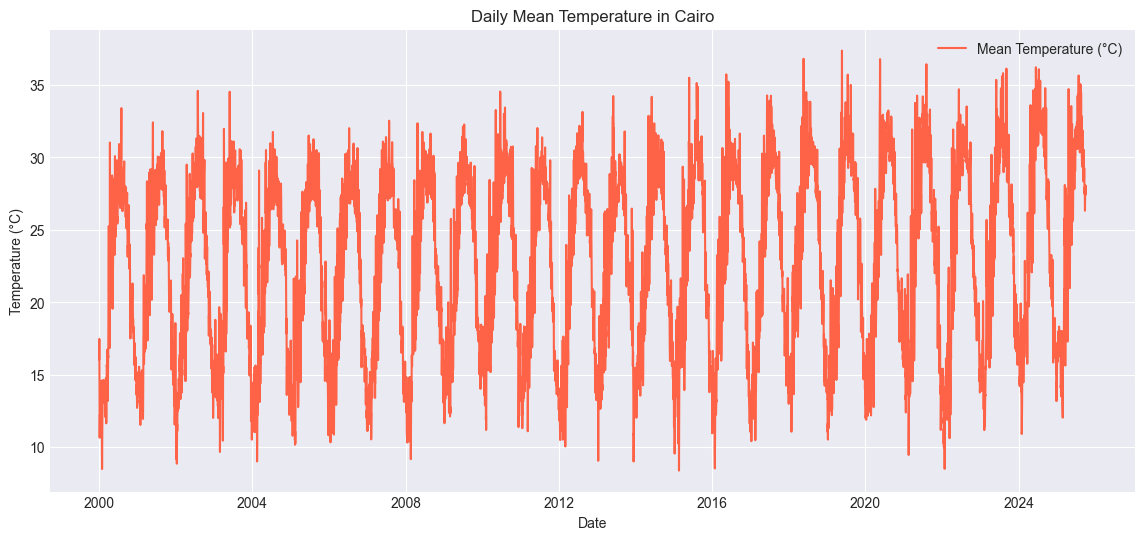

In [14]:
# Quick Visual Check of Main Variables
# ============================================================

plt.figure(figsize=(14,6))
plt.plot(df.index, df['temperature_2m_mean'], label='Mean Temperature (°C)', color='tomato')
plt.title("Daily Mean Temperature in Cairo")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

In [15]:
df['month'] = df.index.month
df['year'] = df.index.year

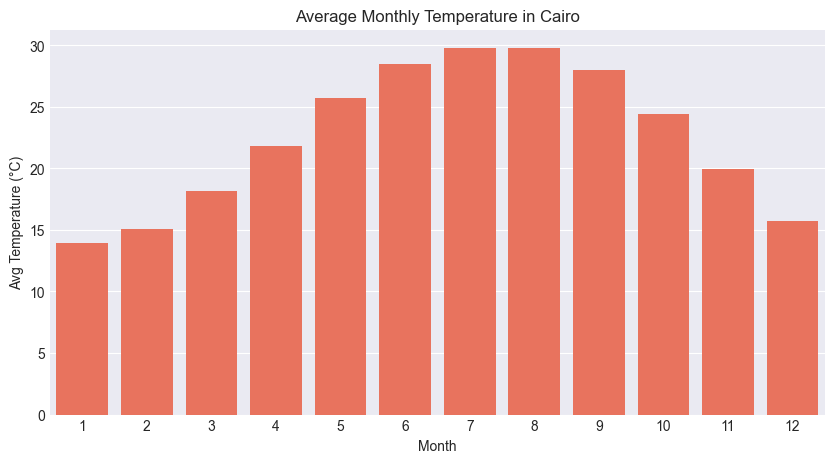

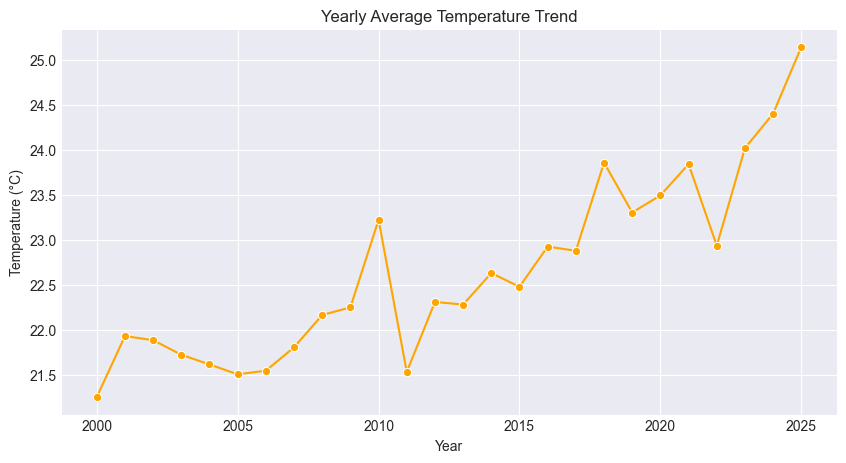

In [17]:
# Monthly averages
monthly_temp = df.groupby('month')['temperature_2m_mean'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=monthly_temp.index, y=monthly_temp.values, color='tomato')
plt.title("Average Monthly Temperature in Cairo")
plt.xlabel("Month")
plt.ylabel("Avg Temperature (°C)")
plt.show()

# Yearly trend
yearly_temp = df.groupby('year')['temperature_2m_mean'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=yearly_temp.index, y=yearly_temp.values, marker='o', color='orange')
plt.title("Yearly Average Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

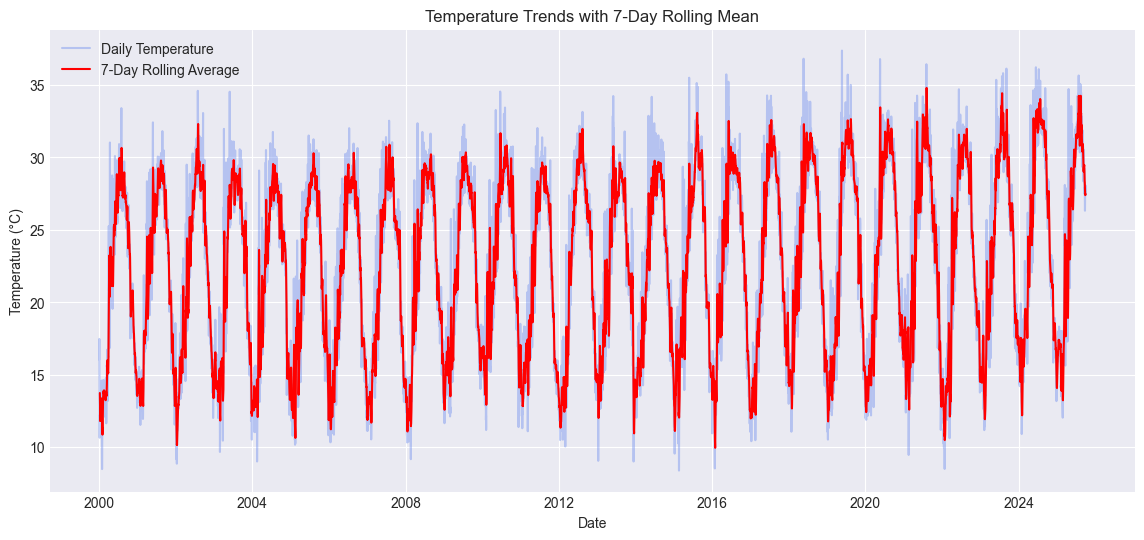

In [18]:
# Compute 7-day rolling average for smoothing
df['temp_roll7'] = df['temperature_2m_mean'].rolling(window=7).mean()

plt.figure(figsize=(14,6))
plt.plot(df.index, df['temperature_2m_mean'], alpha=0.4, label='Daily Temperature')
plt.plot(df.index, df['temp_roll7'], color='red', label='7-Day Rolling Average')
plt.title("Temperature Trends with 7-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

In [21]:
# ============================================================
# Stationarity Check 
# ============================================================

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['temperature_2m_mean'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("✅ Data is likely stationary.")
else:
    print("⚠️ Data is non-stationary, may require differencing or detrending.")


ADF Statistic: -7.429458847402546
p-value: 6.417766528578714e-11
✅ Data is likely stationary.


### ✅ EDA Complete

Key Insights:
1. Cairo shows clear seasonal temperature patterns — hot summers, mild winters.
2. Data appears clean and consistent, with no missing values.
3. Ready for normalization and sequence generation for LSTM modeling.


### LSTM Weather Forecasting Pipeline

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math

In [23]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load cleaned dataset
df = pd.read_csv("Cairo-Weather.csv", parse_dates=['date'], index_col='date')

# Keep only the target column
data = df[['temperature_2m_mean']].copy()
data = data.dropna()
data.head()

Using device: cpu


,temperature_2m_mean
date,
2000-01-01 00:00:00+00:00,16.036583
2000-01-02 00:00:00+00:00,17.465748
2000-01-03 00:00:00+00:00,15.282417
2000-01-04 00:00:00+00:00,12.326167
2000-01-05 00:00:00+00:00,10.642833


In [24]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [25]:
# Sequence Creation Function
# ============================================================

def create_sequences(dataset, lookback=30, forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset) - lookback - forecast_horizon + 1):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[(i + lookback):(i + lookback + forecast_horizon), 0])
    return np.array(X), np.array(y)

LOOKBACK = 30
FORECAST_HORIZON = 1  # set to >1 for multi-step

X, y = create_sequences(scaled_data, LOOKBACK, FORECAST_HORIZON)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (9376, 30), y shape: (9376, 1)


In [26]:
# ============================================================
# PyTorch Dataset
# ============================================================

class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # [samples, lookback, 1]
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/test split
split = int(0.8 * len(X))
train_dataset = WeatherDataset(X[:split], y[:split])
test_dataset = WeatherDataset(X[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [27]:
# ============================================================
# LSTM Model Definition
# ============================================================

class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch, seq_len, features]
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take output from last time step
        out = self.fc(out)
        return out


In [28]:
# ============================================================
# Training Loop
# ============================================================

model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item()
    val_loss /= len(test_loader)
    
    train_losses.append(np.mean(batch_losses))
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}]  Train Loss: {np.mean(batch_losses):.6f}  Val Loss: {val_loss:.6f}")


Epoch [1/50]  Train Loss: 0.018484  Val Loss: 0.007209
Epoch [2/50]  Train Loss: 0.005962  Val Loss: 0.008584
Epoch [3/50]  Train Loss: 0.005656  Val Loss: 0.006304
Epoch [4/50]  Train Loss: 0.005046  Val Loss: 0.006404
Epoch [5/50]  Train Loss: 0.004505  Val Loss: 0.004118
Epoch [6/50]  Train Loss: 0.003787  Val Loss: 0.003048
Epoch [7/50]  Train Loss: 0.003405  Val Loss: 0.002762
Epoch [8/50]  Train Loss: 0.003268  Val Loss: 0.002848
Epoch [9/50]  Train Loss: 0.003298  Val Loss: 0.002648
Epoch [10/50]  Train Loss: 0.003094  Val Loss: 0.002665
Epoch [11/50]  Train Loss: 0.003011  Val Loss: 0.002950
Epoch [12/50]  Train Loss: 0.002992  Val Loss: 0.002612
Epoch [13/50]  Train Loss: 0.002949  Val Loss: 0.002600
Epoch [14/50]  Train Loss: 0.002959  Val Loss: 0.002564
Epoch [15/50]  Train Loss: 0.002852  Val Loss: 0.002593
Epoch [16/50]  Train Loss: 0.002901  Val Loss: 0.002756
Epoch [17/50]  Train Loss: 0.002871  Val Loss: 0.002822
Epoch [18/50]  Train Loss: 0.002960  Val Loss: 0.002531
E

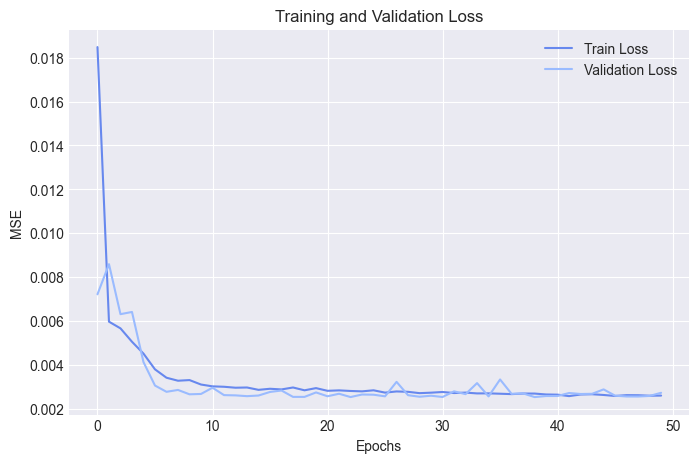

In [29]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE: 1.107 | RMSE: 1.514


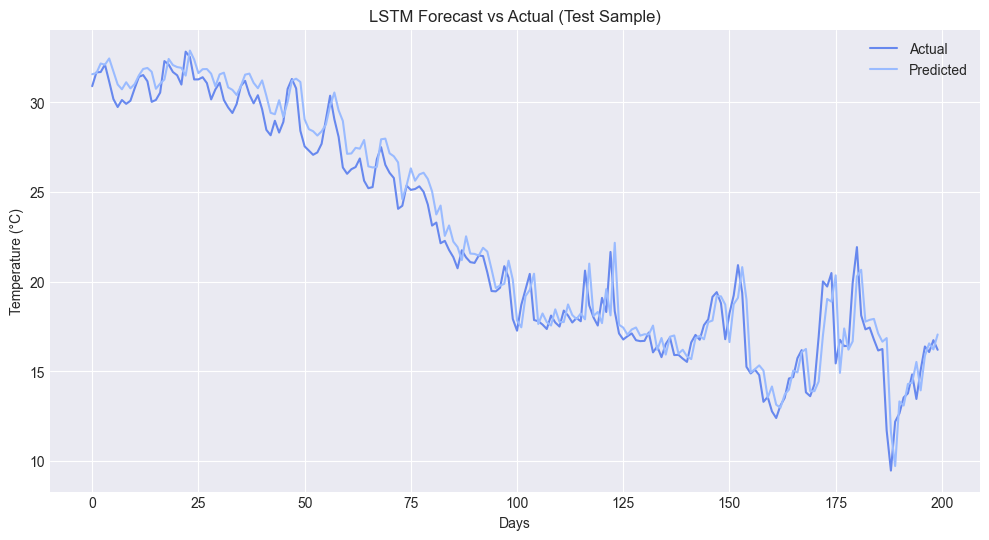

In [30]:
# ============================================================
# Model Evaluation
# ============================================================

model.eval()
preds, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

# Inverse scale
preds_inv = scaler.inverse_transform(preds)
actuals_inv = scaler.inverse_transform(actuals)

mae = mean_absolute_error(actuals_inv, preds_inv)
rmse = math.sqrt(mean_squared_error(actuals_inv, preds_inv))
print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f}")

plt.figure(figsize=(12,6))
plt.plot(actuals_inv[:200], label='Actual')
plt.plot(preds_inv[:200], label='Predicted')
plt.title("LSTM Forecast vs Actual (Test Sample)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [31]:
# ============================================================
# Rolling Multi-Step Forecast
# ============================================================

def forecast_future(model, data, lookback=30, steps=7):
    model.eval()
    seq = data[-lookback:].reshape(1, lookback, 1)
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    preds = []
    
    with torch.no_grad():
        for _ in range(steps):
            y_pred = model(seq).cpu().numpy().flatten()
            preds.append(y_pred[-1])
            new_input = np.append(seq.cpu().numpy().flatten(), y_pred[-1])
            seq = torch.tensor(new_input[-lookback:].reshape(1, lookback, 1), dtype=torch.float32).to(device)
    
    return scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Example: 7-day forecast
future_preds = forecast_future(model, scaled_data, lookback=LOOKBACK, steps=7)
print("Next 7-day forecast (°C):", future_preds.flatten())


Next 7-day forecast (°C): [28.200258 29.155382 29.661633 29.967104 30.26464  30.528036 30.750967]


In [32]:
torch.save(model.state_dict(), "cairo_lstm_torch.pt")
import joblib
joblib.dump(scaler, "scaler.save")
print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!
